<a href="https://colab.research.google.com/github/JhonaCode/LASSO/blob/main/lasso_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Script to read LASSO 2m-Temperature using just XArray

### IMPORT PYTHON FUNCTIONS

We start by installing some packages that are not available by default on Google-Colab. 

In [ ]:
#try:
#  import netCDF4
#  import metpy
#  import wrf_python
#except ImportError:
#!pip install netCDF4
#  !pip install metpy
#  !pip install wrf-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 44.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 56.4 MB/s eta 0:00:00


Now the regular imports 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import netCDF4 as nc
#from metpy.units import *
#from metpy.calc import density
from scipy.special import gamma

import h5py,bokeh,seaborn,dask,distributed
import notebook,pandas,xarray,graphviz,pandas_datareader

import xarray as xr
#import wrf 

We want to connect to the Google Drive.

### ****Function to print information of NetCDF4 files****

In [ ]:
def ncdump(nc_fid, verb=True):
    '''
    ncdump outputs dimensions, variables and their attribute information.
    The information is similar to that of NCAR's ncdump utility.
    ncdump requires a valid instance of Dataset.

    Parameters
    ----------
    nc_fid : netCDF4.Dataset
        A netCDF4 dateset object
    verb : Boolean
        whether or not nc_attrs, nc_dims, and nc_vars are printed

    Returns
    -------
    nc_attrs : list
        A Python list of the NetCDF file global attributes
    nc_dims : list
        A Python list of the NetCDF file dimensions
    nc_vars : list
        A Python list of the NetCDF file variables
    '''
    def print_ncattr(key):
        """
        Prints the NetCDF file attributes for a given key

        Parameters
        ----------
        key : unicode
            a valid netCDF4.Dataset.variables key
        """
        try:
            print("\t\ttype:", repr(nc_fid.variables[key].dtype))
            for ncattr in nc_fid.variables[key].ncattrs():
                print('\t\t%s:' % ncattr,\
                      repr(nc_fid.variables[key].getncattr(ncattr)))
        except KeyError:
            print( "\t\tWARNING: %s does not contain variable attributes" % key)

    # NetCDF global attributes
    nc_attrs = nc_fid.ncattrs()
    if verb:
        print ("NetCDF Global Attributes:")
        for nc_attr in nc_attrs:
            print ('\t%s:' % nc_attr, repr(nc_fid.getncattr(nc_attr)))
    nc_dims = [dim for dim in nc_fid.dimensions]  # list of nc dimensions
    # Dimension shape information.
    if verb:
        print ("NetCDF dimension information:")
        for dim in nc_dims:
            print("\tName:", dim)
            print("\t\tsize:", len(nc_fid.dimensions[dim]))
            print_ncattr(dim)
    # Variable information.
    nc_vars = [var for var in nc_fid.variables]  # list of nc variables
    if verb:
        print("NetCDF variable information:")
        for var in nc_vars:
            if var not in nc_dims:
                print( '\tName:', var)
                print( "\t\tdimensions:", nc_fid.variables[var].dimensions)
                print( "\t\tsize:", nc_fid.variables[var].size)
                print_ncattr(var)
    return nc_attrs, nc_dims, nc_vars

**bold text**### To load the ncfiles from shared **Drive** 

In [ ]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# Make sure we can list the files in our shared folder 

!ls drive/Shareddrives/LASSO_G_COLAB

sgplasso  sgpotherobs  Test


In [82]:
# path to with the model output for the simulation we will work with 
data_path = 'drive/Shareddrives/LASSO_G_COLAB/sgplasso/20190517/raw_model/'
!ls drive/Shareddrives/LASSO_G_COLAB/sgplasso/20190517/raw_model/

wrfout_d01_2019-05-17_12:00:00.nc  wrfout_d01_2019-05-17_21:00:00.nc
wrfout_d01_2019-05-17_13:00:00.nc  wrfout_d01_2019-05-17_22:00:00.nc
wrfout_d01_2019-05-17_14:00:00.nc  wrfout_d01_2019-05-17_23:00:00.nc
wrfout_d01_2019-05-17_15:00:00.nc  wrfout_d01_2019-05-18_00:00:00.nc
wrfout_d01_2019-05-17_16:00:00.nc  wrfout_d01_2019-05-18_01:00:00.nc
wrfout_d01_2019-05-17_17:00:00.nc  wrfout_d01_2019-05-18_02:00:00.nc
wrfout_d01_2019-05-17_18:00:00.nc  wrfout_d01_2019-05-18_03:00:00.nc
wrfout_d01_2019-05-17_19:00:00.nc  wrfstat_d01_2019-05-17_12:00:00.nc
wrfout_d01_2019-05-17_20:00:00.nc


### NetCdf information from ncdump function

In [ ]:
#nc_fit=nc.Dataset('%s%s'%(data_path,'wrfout_d01_2019-05-18_02:00:00.nc'))
nc_fit=nc.Dataset(data_path+'wrfout_d01_2019-05-18_02:00:00.nc')

data_inf= ncdump(nc_fit)


NetCDF Global Attributes:
	TITLE: ' OUTPUT FROM WRF V3.8.1 MODEL'
	START_DATE: '2019-05-17_12:00:00'
	SIMULATION_START_DATE: '2019-05-17_12:00:00'
	WEST-EAST_GRID_DIMENSION: 251
	SOUTH-NORTH_GRID_DIMENSION: 251
	BOTTOM-TOP_GRID_DIMENSION: 227
	DX: 100.0
	DY: 100.0
	SKEBS_ON: 0
	SPEC_BDY_FINAL_MU: 1
	USE_Q_DIABATIC: 0
	GRIDTYPE: 'C'
	DIFF_OPT: 2
	KM_OPT: 2
	DAMP_OPT: 3
	DAMPCOEF: 0.2
	KHDIF: 1.0
	KVDIF: 1.0
	MP_PHYSICS: 8
	RA_LW_PHYSICS: 4
	RA_SW_PHYSICS: 4
	SF_SFCLAY_PHYSICS: 1
	SF_SURFACE_PHYSICS: 1
	BL_PBL_PHYSICS: 0
	CU_PHYSICS: 0
	SF_LAKE_PHYSICS: 0
	SURFACE_INPUT_SOURCE: 3
	SST_UPDATE: 0
	GRID_FDDA: 0
	GFDDA_INTERVAL_M: 0
	GFDDA_END_H: 0
	GRID_SFDDA: 0
	SGFDDA_INTERVAL_M: 0
	SGFDDA_END_H: 0
	HYPSOMETRIC_OPT: 1
	USE_THETA_M: 1
	SF_URBAN_PHYSICS: 0
	SHCU_PHYSICS: 0
	MFSHCONV: 0
	FEEDBACK: 0
	SMOOTH_OPTION: 0
	SWRAD_SCAT: 1.0
	W_DAMPING: 0
	RADT: 1.0
	BLDT: 0.0
	CUDT: 0.0
	AER_OPT: 0
	SWINT_OPT: 0
	AER_TYPE: 1
	AER_AOD550_OPT: 1
	AER_ANGEXP_OPT: 1
	AER_SSA_OPT: 1
	AER_ASY_OPT: 1
	AER

### XRARRY OPEN

In [20]:
# open a single file, just as an example
ncfile = xr.open_dataset(data_path+'wrfout_d01_2019-05-18_02:00:00.nc')

# number of variables in the file
print('Number of variables = ', len(ncfile.variables))

# summary of the file content
ncfile.keys()

Number of variables =  258


KeysView(<xarray.Dataset>
Dimensions:                (Time: 6, south_north: 250, west_east: 250,
                            bottom_top: 226, bottom_top_stag: 227,
                            soil_layers_stag: 5, west_east_stag: 251,
                            south_north_stag: 251, force_layers: 751)
Coordinates:
    XLAT                   (Time, south_north, west_east) float32 ...
    XLONG                  (Time, south_north, west_east) float32 ...
    XTIME                  (Time) datetime64[ns] ...
    XLAT_U                 (Time, south_north, west_east_stag) float32 ...
    XLONG_U                (Time, south_north, west_east_stag) float32 ...
    XLAT_V                 (Time, south_north_stag, west_east) float32 ...
    XLONG_V                (Time, south_north_stag, west_east) float32 ...
Dimensions without coordinates: Time, south_north, west_east, bottom_top,
                                bottom_top_stag, soil_layers_stag,
                                west_east_stag, s

In [ ]:
# list the variables in the file (long list)
list(ncfile.variables)

# only the first 20 variables
#list(ncfile.variables)[:20]

['Times',
 'XLAT',
 'XLONG',
 'LU_INDEX',
 'ZNU',
 'ZNW',
 'ZS',
 'DZS',
 'VAR_SSO',
 'U',
 'V',
 'W',
 'PH',
 'PHB',
 'T',
 'HFX_FORCE',
 'LH_FORCE',
 'TSK_FORCE',
 'HFX_FORCE_TEND',
 'LH_FORCE_TEND',
 'TSK_FORCE_TEND',
 'MU',
 'MUB',
 'NEST_POS',
 'TKE',
 'P',
 'ALT',
 'PB',
 'FNM',
 'FNP',
 'RDNW',
 'RDN',
 'DNW',
 'DN',
 'CFN',
 'CFN1',
 'THIS_IS_AN_IDEAL_RUN',
 'P_HYD',
 'Q2',
 'T2',
 'TH2',
 'PSFC',
 'U10',
 'V10',
 'RDX',
 'RDY',
 'RESM',
 'ZETATOP',
 'CF1',
 'CF2',
 'CF3',
 'ITIMESTEP',
 'XTIME',
 'QVAPOR',
 'QCLOUD',
 'QRAIN',
 'QICE',
 'QSNOW',
 'QGRAUP',
 'QNICE',
 'QNRAIN',
 'SHDMAX',
 'SHDMIN',
 'SNOALB',
 'TSLB',
 'SMOIS',
 'SH2O',
 'SEAICE',
 'XICEM',
 'SFROFF',
 'UDROFF',
 'IVGTYP',
 'ISLTYP',
 'VEGFRA',
 'GRDFLX',
 'ACGRDFLX',
 'ACSNOM',
 'SNOW',
 'SNOWH',
 'CANWAT',
 'SSTSK',
 'COSZEN',
 'LAI',
 'VAR',
 'MAPFAC_M',
 'MAPFAC_U',
 'MAPFAC_V',
 'MAPFAC_MX',
 'MAPFAC_MY',
 'MAPFAC_UX',
 'MAPFAC_UY',
 'MAPFAC_VX',
 'MF_VX_INV',
 'MAPFAC_VY',
 'F',
 'E',
 'SINALPHA',
 'COSA

### Specific information  

In [ ]:
# if you want to know more info on a variable
ncfile['T2']

<xarray.DataArray 'T2' (Time: 1, south_north: 250, west_east: 250)>
array([[[293.96518, 293.98007, ..., 293.96286, 293.96008],
        [293.9567 , 293.97083, ..., 293.95786, 293.95514],
        ...,
        [293.97934, 293.98862, ..., 293.9618 , 293.96765],
        [293.97504, 293.9851 , ..., 293.963  , 293.96268]]], dtype=float32)
Coordinates:
    XLAT     (Time, south_north, west_east) float32 ...
    XLONG    (Time, south_north, west_east) float32 ...
    XTIME    (Time) datetime64[ns] ...
Dimensions without coordinates: Time, south_north, west_east
Attributes:
    FieldType:    104
    MemoryOrder:  XY 
    description:  TEMP at 2 M
    units:        K
    stagger:

In [22]:
# if you want to know more info on a variable
ncfile['CLDFRA']

<xarray.DataArray 'CLDFRA' (Time: 6, bottom_top: 226, south_north: 250,
                            west_east: 250)>
[84750000 values with dtype=float32]
Coordinates:
    XLAT     (Time, south_north, west_east) float32 ...
    XLONG    (Time, south_north, west_east) float32 ...
    XTIME    (Time) datetime64[ns] ...
Dimensions without coordinates: Time, bottom_top, south_north, west_east
Attributes:
    FieldType:    104
    MemoryOrder:  XYZ
    description:  CLOUD FRACTION
    units:        
    stagger:

In [ ]:
# get the temperature
T2 = ncfile['T2']
# and print its dimensions 
print(T2.shape)
np.unique(T2)

(6, 250, 250)


array([293.94464, 293.94742, 293.9476 , ..., 296.85486, 296.8629 ,
       296.8636 ], dtype=float32)

### PLOT TEMPERATURE 

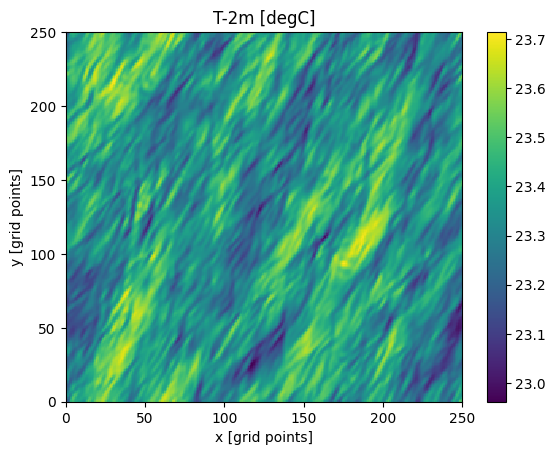

In [ ]:
# plot last time of the first file (~ 1h). 
# this should be after 1h of simulation. Because LES is initialized with uniform
# fields, the initial differences are very small. 
cf = plt.pcolormesh(T2[0,:,:] - 273.15)
plt.xlabel('x [grid points]')
plt.ylabel('y [grid points]')
plt.title('T-2m [degC]')
plt.colorbar(cf)

### PLOT CLOUD FRACTION 



<ipython-input-95-babe3adc1b10>:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3, 2, 1)


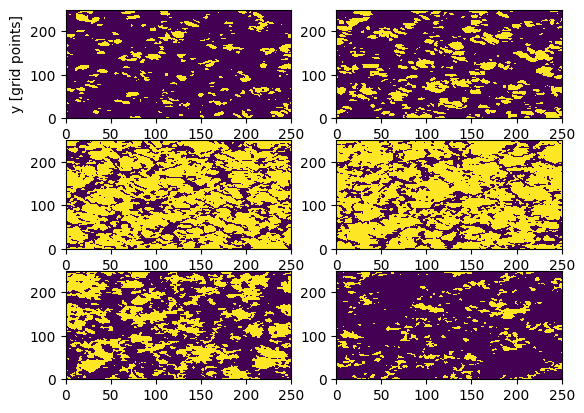

In [95]:

plt.title('Cloud Fraction ')

plt.subplot(3, 2, 1)

plt.xlabel('x [grid points]')
plt.ylabel('y [grid points]')
cf = plt.pcolormesh(CLD[40,50,:,:] )

plt.subplot(3, 2, 2)
cf = plt.pcolormesh(CLD[45,50,:,:] )

plt.subplot(3, 2, 3)
cf = plt.pcolormesh(CLD[50,50,:,:] )

plt.subplot(3, 2, 4)
cf = plt.pcolormesh(CLD[55,50,:,:] )

plt.subplot(3, 2, 5)
cf = plt.pcolormesh(CLD[60,50,:,:] )

plt.subplot(3, 2, 6)
cf = plt.pcolormesh(CLD[65,50,:,:] )

#plt.subplot(3, 3, 1)
#plt.colorbar(cf)

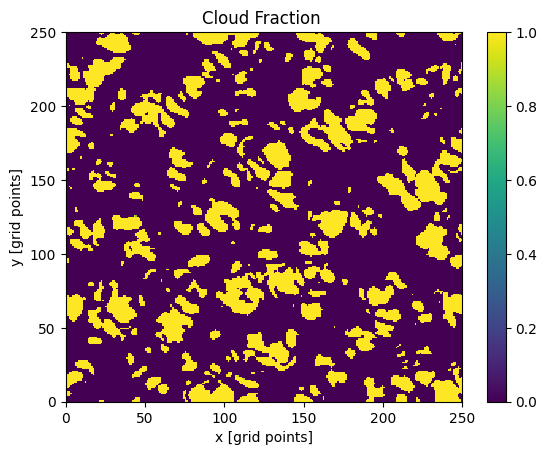

In [81]:
cf = plt.pcolormesh(CLD[45,50,:,:] )
plt.xlabel('x [grid points]')
plt.ylabel('y [grid points]')
plt.title('Cloud Fraction ')
plt.colorbar(cf)

In [31]:
?xr.open_mfdataset

In [39]:
# now let's open all the files

# these files are not CF-compliant, so we have to force concatenation on the time dimension
ncfile = xr.open_mfdataset(data_path+'wrfout_d01_2019-05-*.nc', combine='nested', concat_dim='Time',decode_cf=False)

In [46]:
from pickle import TUPLE3
# what do we have now? 

T2  = ncfile['T2']
CLD = ncfile['CLDFRA']

np.shape(T2)
#T2

(91, 250, 250)

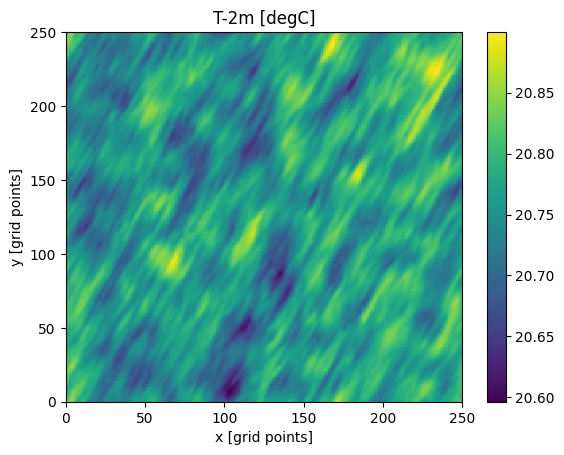

In [48]:
# plot last time of the multi-file dataset (~15h after start). 

cf = plt.pcolormesh(T2[90,:,:] - 273.15)
plt.xlabel('x [grid points]')
plt.ylabel('y [grid points]')
plt.title('T-2m [degC]')
plt.colorbar(cf)

Where are the clouds? 

In [49]:
QCLD = ncfile['QCLOUD']
QCLD


<xarray.DataArray 'QCLOUD' (Time: 91, bottom_top: 226, south_north: 250,
                            west_east: 250)>
dask.array<concatenate, shape=(91, 226, 250, 250), dtype=float32, chunksize=(6, 226, 250, 250), chunktype=numpy.ndarray>
Dimensions without coordinates: Time, bottom_top, south_north, west_east
Attributes:
    FieldType:    104
    MemoryOrder:  XYZ
    description:  Cloud water mixing ratio
    units:        kg kg-1
    stagger:      
    coordinates:  XLONG XLAT XTIME

In [53]:
# domain mean vertical profile of QCLD
QCLD_PROF  = np.mean(QCLD, axis=(2,3))
CLD_PROF = np.mean(CLD, axis=(2,3))
QCLD_PROF

#plt.plot(QCLDPROF[0,:])

<xarray.DataArray 'QCLOUD' (Time: 91, bottom_top: 226)>
dask.array<mean_agg-aggregate, shape=(91, 226), dtype=float32, chunksize=(6, 226), chunktype=numpy.ndarray>
Dimensions without coordinates: Time, bottom_top

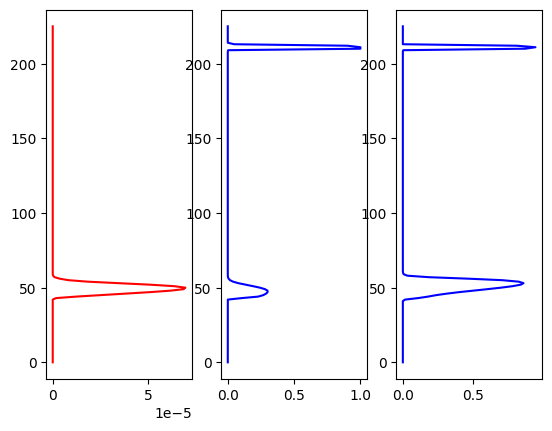

In [96]:
# make a plot
#fig=plt.figure()
#ax=plt.axes()
plt.subplot(1, 3, 1)
plt.plot(QCLD_PROF[45,:], np.arange(226), 'r')
plt.subplot(1, 3, 2)
plt.plot(CLD_PROF[45,:] , np.arange(226), 'b')

plt.subplot(1, 3, 3)
plt.plot(CLD_PROF[55,:] , np.arange(226), 'b')

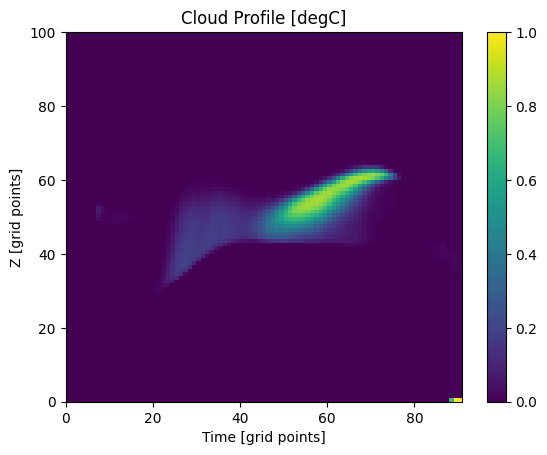

In [77]:
cf = plt.pcolormesh(CLD_PROF[:,0:100].T)
plt.xlabel('Time [grid points]')
plt.ylabel('Z [grid points]')
plt.title('Cloud Fraction Profile [degC]')
plt.colorbar(cf)

### LIQUID WATER PATH

In [73]:
LWP = np.sum(QCLD, axis=1)*50.*1.1
LWP

<xarray.DataArray 'QCLOUD' (Time: 91, south_north: 250, west_east: 250)>
dask.array<mul, shape=(91, 250, 250), dtype=float32, chunksize=(6, 250, 250), chunktype=numpy.ndarray>
Dimensions without coordinates: Time, south_north, west_east

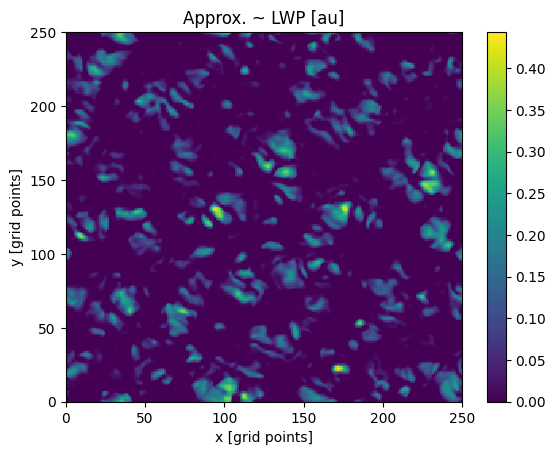

In [ ]:
cf = plt.pcolormesh(LWP[45, :,:])
plt.xlabel('x [grid points]')
plt.ylabel('y [grid points]')
plt.title('Approx. ~ LWP [au]')
plt.colorbar(cf)

In [ ]:
from skimage import measure
from skimage import filters

last label =  188


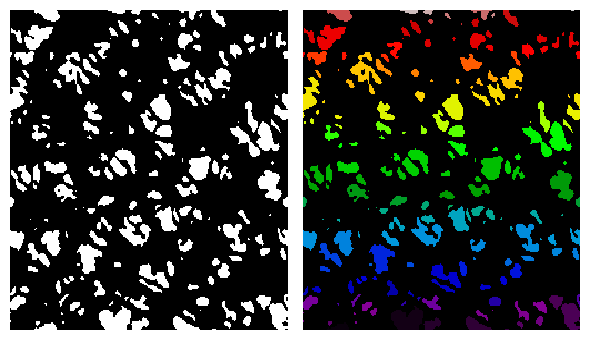

In [ ]:
blobs = LWP[45,:,:] > 0.05

labels = measure.label(blobs, background=0)
print('last label = ', np.max(labels))

plt.figure(figsize=(6, 3.5))
plt.subplot(121)
plt.pcolormesh(blobs, cmap='gray')
plt.axis('off')
plt.subplot(122)
plt.pcolormesh(labels, cmap='nipy_spectral')
plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
properties = measure.regionprops(labels)
areas = [prop.area for prop in properties] 

print('min area = ', np.min(areas))
print('max area = ', np.max(areas))
len(areas)

min area =  1
max area =  387


188

(array([46., 16., 23., 18., 13.,  9.,  7.,  8.,  8.,  4.,  3.,  3.,  4.,
         3.,  3.,  2.,  0.,  1.,  0.,  0.,  1.,  3.,  1.,  1.,  1.,  1.,
         0.,  3.,  0.,  2.,  0.,  2.,  0.,  0.,  0.,  1.,  0.,  0.,  1.]),
 array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.,
        110., 120., 130., 140., 150., 160., 170., 180., 190., 200., 210.,
        220., 230., 240., 250., 260., 270., 280., 290., 300., 310., 320.,
        330., 340., 350., 360., 370., 380., 390.]),
 <BarContainer object of 39 artists>)

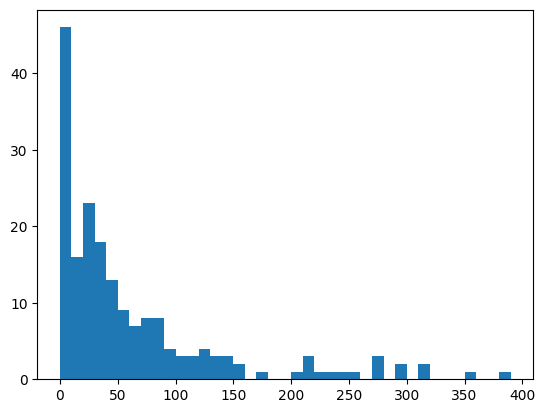

In [ ]:
plt.hist(areas,bins=np.arange(0,400, 10))

In [ ]:
properties[0].coords
center = np.array( [prop.centroid for prop in properties] )
center.shape
center[0:3]

array([[  1.67142857,  33.54285714],
       [  7.71317829,  94.42894057],
       [  3.88888889, 116.45454545]])

In [ ]:
center.shape

(188, 2)

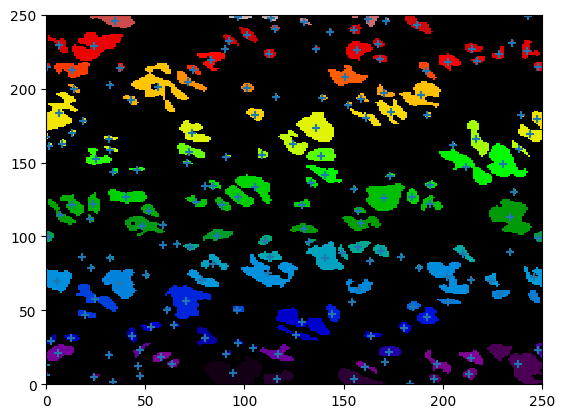

In [ ]:
plt.pcolormesh(labels, cmap='nipy_spectral')

plt.scatter(center[:,1], center[:,0], marker='+')

In [ ]:
areas

[70,
 387,
 99,
 139,
 4,
 350,
 22,
 12,
 40,
 4,
 2,
 35,
 75,
 24,
 3,
 1,
 71,
 46,
 1,
 104,
 93,
 26,
 20,
 3,
 8,
 67,
 7,
 76,
 12,
 20,
 37,
 29,
 59,
 32,
 211,
 32,
 31,
 9,
 87,
 60,
 295,
 33,
 145,
 23,
 6,
 31,
 38,
 3,
 37,
 232,
 44,
 83,
 241,
 151,
 276,
 84,
 41,
 71,
 3,
 7,
 65,
 213,
 8,
 2,
 58,
 3,
 46,
 7,
 25,
 1,
 49,
 3,
 61,
 3,
 25,
 1,
 34,
 11,
 1,
 25,
 24,
 80,
 140,
 319,
 65,
 119,
 74,
 1,
 10,
 47,
 94,
 66,
 19,
 44,
 273,
 59,
 45,
 122,
 31,
 140,
 171,
 50,
 5,
 3,
 27,
 24,
 21,
 1,
 217,
 104,
 11,
 272,
 11,
 15,
 82,
 8,
 109,
 77,
 5,
 26,
 127,
 28,
 118,
 13,
 4,
 12,
 1,
 130,
 252,
 88,
 16,
 5,
 9,
 228,
 43,
 61,
 127,
 5,
 53,
 8,
 4,
 319,
 206,
 6,
 31,
 22,
 12,
 4,
 43,
 18,
 78,
 32,
 2,
 150,
 46,
 128,
 28,
 18,
 92,
 81,
 20,
 6,
 26,
 27,
 292,
 116,
 32,
 59,
 31,
 55,
 44,
 5,
 1,
 24,
 33,
 5,
 54,
 32,
 87,
 2,
 14,
 133,
 57,
 16,
 7,
 25,
 34,
 3]